## On Machine Learning in Pro/Notebook with Spark

Notebook to demonstrate the usage of the ArcGIS Pro built-in [Apache Spark](https://spark.apache.org) in preparing data for machine learning training.

We will be using the [Forest-based Classification and Regression (Spatial Statistics)](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/forestbasedclassificationregression.htm) GeoProcessing task to predict (or attempt to predict) the duration of a NYC taxi trip given a pickup location, a dropoff location, and a time of day.

This process is inspired by [this](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) Kaggle competition, and the data can be download from [here](https://www.kaggle.com/c/nyc-taxi-trip-duration/data).

This notebook also demonstrates the usage of [Pandas User Defined Functions](https://docs.databricks.com/spark/latest/spark-sql/udf-python-pandas.html) to geo-enrich the data.

Please read the instructions in the `README` file to setup your conda environment with the required python modules.

### Import Esri Spark module.

In [1]:
from spark_esri import spark_start, spark_stop

In [2]:
import os
import arcpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.functions import pandas_udf, hour, cos, sin, radians, col
from pyspark.sql.types import DoubleType

### Inline all the plots and set the theme of the plots to dark mode.

Note: Do the latter only if your ArcGIS Pro theme is set to dark mode.

In [3]:
%matplotlib inline

plt.style.use('dark_background')

### Start a Spark instance and keep a reference to it.

In [4]:
spark_stop() # Stop if one is running.

config = {"spark.driver.memory":"2G"}
spark = spark_start(config=config)

### Defined 2 UDFs to project the coordinates from WGS84 to WebMercator meters.

In [5]:
@pandas_udf(returnType=DoubleType())
def lonToX(lon:pd.Series)->pd.Series:
    return 6378137.0 * np.radians(lon)

@pandas_udf(returnType=DoubleType())
def latToY(lat:pd.Series)->pd.Series:
    return 6378137.0 * np.log(np.tan((math.pi * 0.25) + (0.5 * np.radians(lat))))

### Define a function to calculate the [havesine](https://en.wikipedia.org/wiki/Haversine_formula) distance between 2 points in decimal degrees.

In [6]:
@pandas_udf("double")
def haversine(lon1:pd.Series,lat1:pd.Series,lon2:pd.Series,lat2:pd.Series)->pd.Series:
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat*0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon*0.5)**2
    return 6378137.0 * 2.0 * np.arcsin(np.sqrt(a))

### Read the NYC Taxi data from a CSV file.

- Adjust the `load_path` variable to your own path, if you want to replicate this notebook.
- I know this data pretty well, and I know it is "spatially noisy", so I'm spatially restricting it to an area around Manhattan.
- A trip duration should be greater than 2 minutes and not take more 100 minutes in that area.
- I'm dropping columns that I will not be using as explanatory variables.
- I'm geo-enriching the dataframe with 2 new columns:
    - `meters`: The haversine distance in meters between the pickup location and dropoff location.
    - `pickup_hour`: The pickup hour derived from the `pickup_datetime` column.
    
- Finally, I wanted the 23rd hour of the day to be "near" the first hour of the day, so I enriched the hour with its cosine and sine values to infer a "cyclic" behaviour.

In [7]:
schema = ",".join([
    "id string",
    "vendor_id string",
    "pickup_datetime timestamp",
    "dropoff_datetime timestamp",
    "passenger_count string",
    "pickup_longitude double",
    "pickup_latitude double",
    "dropoff_longitude double",
    "dropoff_latitude double",
    "store_and_fwd_flag string",
    "trip_duration double"
])

load_path = os.path.join("Z:",os.sep,"Kaggle","nyc-taxi-trip-duration","train.csv")

xmin,ymin,xmax,ymax = (-74.2555913638106, 40.496115395209344, -73.70000906387119, 40.91553277600007)

where = " and ".join([
    f"pickup_longitude between {xmin} and {xmax}",
    f"pickup_latitude between {ymin} and {ymax}",
    f"dropoff_longitude between {xmin} and {xmax}",
    f"dropoff_latitude between {ymin} and {ymax}",
    "trip_duration between 120 and 6000"
])

df = spark\
    .read\
    .format("csv")\
    .option("header", True)\
    .option("parserLib", "univocity")\
    .option("mode", "permissive")\
    .schema(schema)\
    .load(load_path)\
    .where(where)\
    .withColumn("meters", haversine("pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"))\
    .withColumn("pickup_hour", hour("pickup_datetime"))\
    .withColumn("hour_rad", radians(360.0*col("pickup_hour")/23.0))\
    .withColumn("hour_cos", cos("hour_rad"))\
    .withColumn("hour_sin", sin("hour_rad"))\
    .drop("id","vendor_id","passenger_count","store_and_fwd_flag","hour_rad","pickup_datetime","dropoff_datetime")\
    .persist()

df.createOrReplaceTempView("v0")

### Let's get some insight from the data.

### Plot average travel distance by hour.

Note that as of this writing (Aug 22, 2020):

- Though [Arrow](https://arrow.apache.org/) is [enabled](https://docs.databricks.com/spark/latest/spark-sql/spark-pandas.html), the `toPandas()` function off a dataframe throws an expection. Had to revert back to pyarrow=0.8.0.  BTW, this is not the case for Spark 2.4.6+ on my MacBook Pro.  So, we `collect()` the data and explicitly create a Pandas dataframe.
- We have to explicitly call `plt.show()` when in a notebook in Pro for the plots to show.

<Figure size 432x288 with 0 Axes>

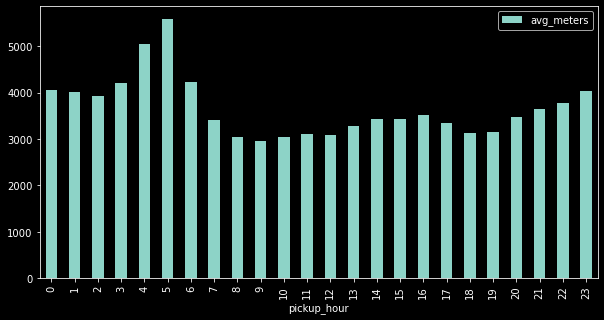

In [8]:
rows = spark.sql(f"""
select pickup_hour,avg(meters) avg_meters
from v0
group by pickup_hour
order by pickup_hour
""")\
    .collect()

pdf = pd.DataFrame(rows,columns=['pickup_hour','avg_meters'])

plt.clf() # Clear figure
pdf.plot(x='pickup_hour',y='avg_meters',kind='bar',figsize=(10,5))
plt.show()

### Plot the number of pickups by hour.

<Figure size 432x288 with 0 Axes>

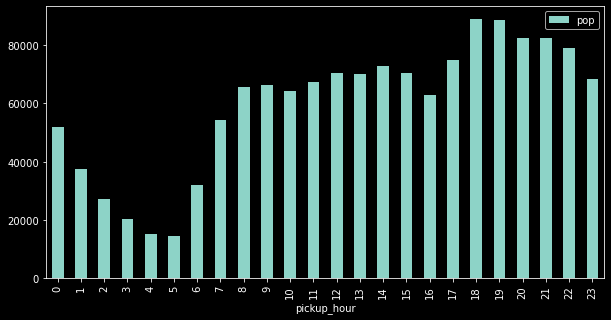

In [9]:
rows = spark.sql(f"""
select pickup_hour,count(1) pop
from v0
group by pickup_hour
order by pickup_hour
""")\
    .collect()

pdf = pd.DataFrame(rows,columns=['pickup_hour','pop'])

plt.clf()
ax = pdf.plot(x='pickup_hour',y='pop',kind='bar',figsize=(10,5))
plt.show()

### Plot distribution of the values of the prediction variable `trip_duration`.

The Spark DataFrame API does not have a histogram function yet! So we fall back on the RDD API that has a [histogram](https://spark.apache.org/docs/2.4.6/api/python/pyspark.html?highlight=histogram#pyspark.RDD.histogram) function.

In [10]:
values,counts = df\
    .selectExpr('log(trip_duration)')\
    .rdd\
    .flatMap(lambda x:x)\
    .histogram(20)

<Figure size 432x288 with 0 Axes>

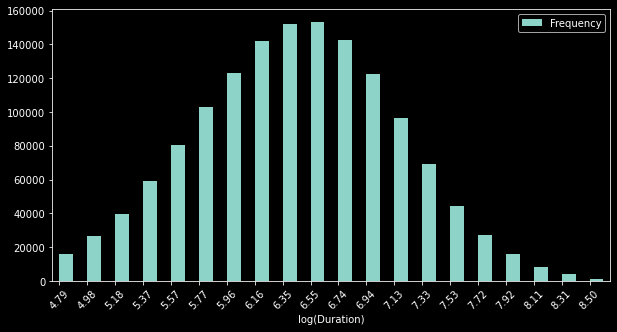

In [11]:
labels = [format(v,'.2f') for v in values]

plt.clf()
ax = pd.DataFrame(list(zip(labels,counts)),columns=['logdur','Frequency'])\
    .set_index('logdur')\
    .plot(kind='bar', figsize=(10,5), align='edge', rot=45, xlabel='log(Duration)')
plt.show()

### Create spatial bins of the data and create a feature class in the ToC.

The spatial binning will be performed in meters, so we will first project the data to web mercator.

Note: Rather than using an inner table for the bins, we will use the `with` statement for clarity.

In [12]:
cell1 = 200.0 # meters
cell2 = cell1 * 0.5

df\
    .select("pickup_longitude","pickup_latitude")\
    .withColumn("px", lonToX("pickup_longitude"))\
    .withColumn("py", latToY("pickup_latitude"))\
    .createOrReplaceTempView("v1")

rows = spark.sql(f"""
with bins as (select cast(px/{cell1} as long) bx,cast(py/{cell1} as long) by from v1)

select bx*{cell1}+{cell2} x,by*{cell1}+{cell2} y,count(1) pop
from bins
group by bx,by
""")\
    .collect()

### Create an in memory feature class of the bin points.

In [13]:
ws = "memory"
nm = "Bins"

fc = os.path.join(ws, nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws, nm, "POINT", spatial_reference=sp_ref)
arcpy.management.AddField(fc, "POP", "LONG")

with arcpy.da.InsertCursor(fc, ["SHAPE@X","SHAPE@Y","POP"]) as cursor:
    for row in rows:
        cursor.insertRow(row)

### Prepare data for ML/GP Regression Task

Note:

- Added `mps` (meters per second) column to enable further filtering to just "moving" trips.
- Added `SHAPE@X` and `SHAPE@Y` fields in web mercator spatial reference, and set the name to the format accepted by ArcPy.

In [14]:
gp = df\
    .drop('pickup_hour')\
    .withColumnRenamed('pickup_longitude','plon')\
    .withColumnRenamed('pickup_latitude','plat')\
    .withColumnRenamed('dropoff_longitude','dlon')\
    .withColumnRenamed('dropoff_latitude','dlat')\
    .withColumnRenamed('trip_duration','duration')\
    .withColumnRenamed('pickup_longitude','plon')\
    .withColumnRenamed('pickup_longitude','plon')\
    .withColumnRenamed('pickup_longitude','plon')\
    .withColumnRenamed('pickup_longitude','plon')\
    .withColumn("mps",col("meters")/col("duration"))\
    .withColumn("SHAPE@X", lonToX("plon"))\
    .withColumn("SHAPE@Y", latToY("plat"))\
    .filter("mps between 0.5 and 10.0")

gp.printSchema()

root
 |-- plon: double (nullable = true)
 |-- plat: double (nullable = true)
 |-- dlon: double (nullable = true)
 |-- dlat: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- meters: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- mps: double (nullable = true)
 |-- SHAPE@X: double (nullable = true)
 |-- SHAPE@Y: double (nullable = true)



### Create training data feature class.

In [15]:
rows = gp.collect()

In [16]:
ws = arcpy.env.scratchGDB  # Forest GP cannot accept memory based ws :-(
nm = "Train"

fields = [f.name for f in gp.schema.fields]

fc = os.path.join(ws, nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws, nm, "POINT", spatial_reference=sp_ref)
for f in fields[:-2]:
    arcpy.management.AddField(fc, f, "DOUBLE")

with arcpy.da.InsertCursor(fc, fields) as cursor:
    for row in rows:
        cursor.insertRow(row)

In [17]:
spark_stop()

### Run [Forest Based Regression](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/how-forest-works.htm) on the feature class.

In [18]:
output = os.path.join(arcpy.env.scratchGDB,"Predictions")

arcpy.gapro.Forest("TRAIN",
                   "Train",
                   output,
                   variable_predict="duration",
                   explanatory_variables="dlat false;dlon false;hour_cos false;hour_sin false;meters false;plat false;plon false",
                   number_of_trees=100,
                   minimum_leaf_size=5,
                   maximum_tree_depth=5)

id,value
0,Z:\ArcGISPro\spark_esri\scratch.gdb\Predictions
1,
2,


A model with an R-Squared of 0.70 off the validation data is generated. Not bad for first time through !

And of course the most important variable is `meters` (67%), which kinda makes sense :-)